In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [3]:
df= pd.read_excel('heart_disease.xlsx',sheet_name='Heart_disease')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0


In [4]:
df.shape

(908, 13)

## Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       908 non-null    int64  
 1   sex       908 non-null    object 
 2   cp        908 non-null    object 
 3   trestbps  908 non-null    int64  
 4   chol      908 non-null    int64  
 5   fbs       908 non-null    bool   
 6   restecg   908 non-null    object 
 7   thalch    908 non-null    int64  
 8   exang     908 non-null    object 
 9   oldpeak   846 non-null    float64
 10  slope     908 non-null    object 
 11  thal      908 non-null    object 
 12  num       908 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 86.1+ KB


In [7]:
df.isnull().sum()   # missing values identified

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64

In [8]:
df.fillna(df['oldpeak'].median(),inplace=True)  # Handling missing values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64

In [9]:
df.duplicated().sum()

1

In [10]:
df.drop_duplicates(inplace=True)  # duplicate values removed
df.duplicated().sum()

0

<Axes: >

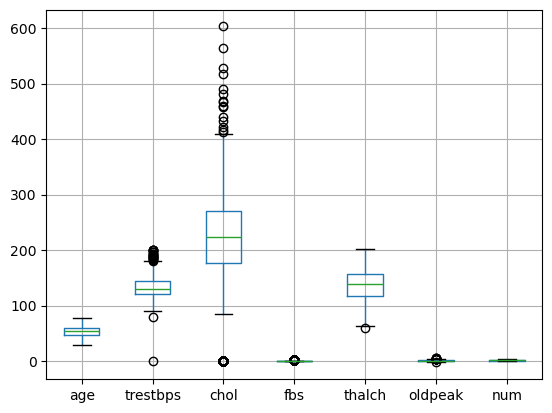

In [11]:
df.boxplot()  # outliers identified

In [12]:
def outliers(df,column):         # outliers removed using IQR method
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR= Q3-Q1
    lower_bound= Q1-1.5*IQR
    upper_bound= Q3+1.5*IQR
    df[column]= df[column].apply(lambda x: lower_bound if x< lower_bound else upper_bound if x>upper_bound else x)
for i in df.select_dtypes(include=['float','int']).columns:
    outliers(df,i)

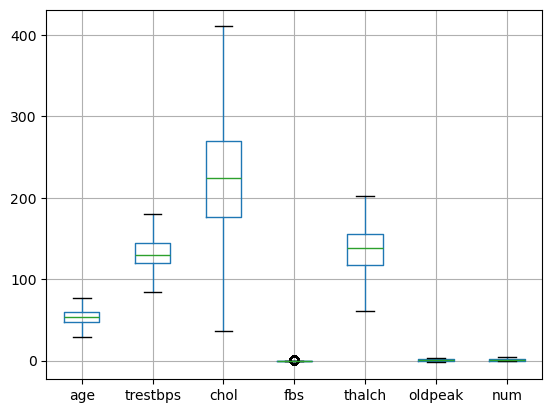

In [13]:
df.boxplot()  # no outliers
plt.show()

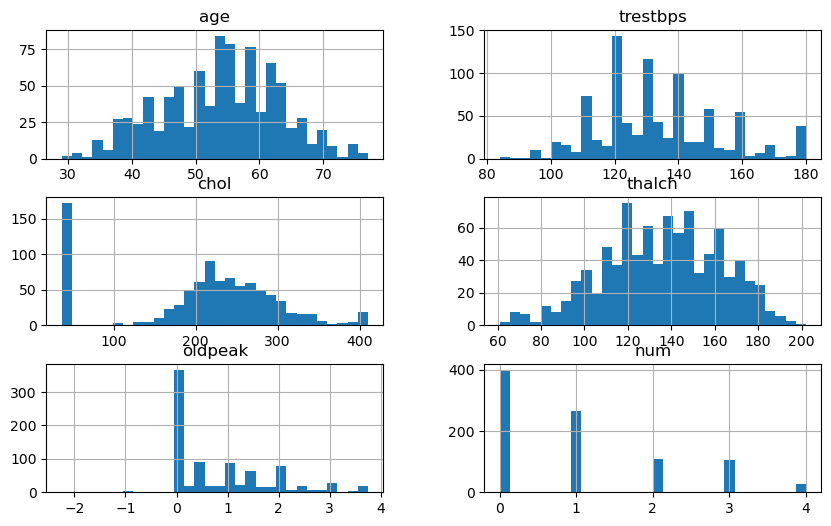

In [14]:
df.hist(figsize=(10,6),bins=30)   # Histogram Visualization
plt.show()

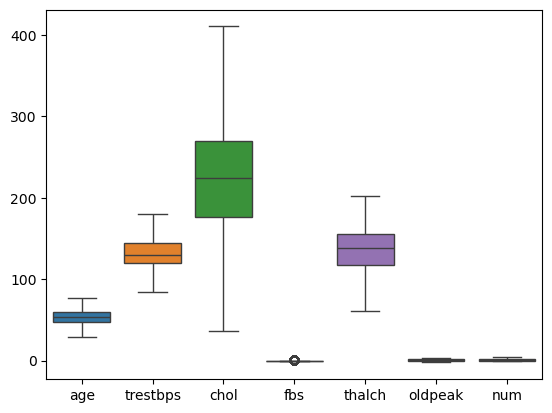

In [15]:
sns.boxplot(df)   # boxplot visualization
plt.show()

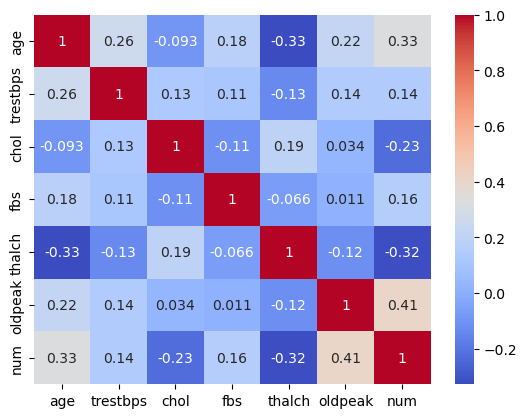

In [16]:
corr= df.corr(numeric_only=True)
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.show()

## Feature Engineering

In [18]:
target= df['num']
target.head()

0    0
1    0
2    0
3    0
4    0
Name: num, dtype: int64

In [19]:
features= df.drop(columns='num')
features.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,fixed defect
1,41,Male,atypical angina,135.0,203.0,False,normal,132.0,False,0.0,flat,fixed defect
2,57,Male,asymptomatic,140.0,192.0,False,normal,148.0,False,0.4,flat,fixed defect
3,52,Male,typical angina,118.0,186.0,False,lv hypertrophy,190.0,False,0.0,flat,fixed defect
4,57,Male,asymptomatic,110.0,201.0,False,normal,126.0,True,1.5,flat,fixed defect


In [20]:
cat_col= features.select_dtypes(include=['object','category']).columns  # categorical columns
cat_col

Index(['sex', 'cp', 'restecg', 'exang', 'slope', 'thal'], dtype='object')

In [21]:
df_encoded= pd.get_dummies(features,columns=cat_col,drop_first=True)   # encoding categorical columns
df_encoded

,age,trestbps,chol,fbs,thalch,oldpeak,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,exang_True,exang_FALSE,exang_TURE,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,145.0,233.00,True,150.0,2.3,True,False,False,True,False,False,False,False,False,False,False,False,False
1,41,135.0,203.00,False,132.0,0.0,True,True,False,False,True,False,False,False,False,True,False,False,False
2,57,140.0,192.00,False,148.0,0.4,True,False,False,False,True,False,False,False,False,True,False,False,False
3,52,118.0,186.00,False,190.0,0.0,True,False,False,True,False,False,False,False,False,True,False,False,False
4,57,110.0,201.00,False,126.0,1.5,True,False,False,False,True,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,53,125.0,36.25,False,120.0,1.5,True,False,False,False,True,False,False,False,False,False,True,False,True
904,62,166.0,170.00,False,120.0,3.0,True,False,False,False,False,True,True,False,False,True,False,False,True
905,56,170.0,36.25,False,123.0,2.5,True,False,True,False,False,False,True,False,False,False,False,True,False
906,56,144.0,208.00,True,105.0,0.5,True,False,True,False,False,True,False,False,True,False,False,False,False


In [22]:
num_col= features.select_dtypes(include=['float','int']) # numerical columns
num_col

,age,trestbps,chol,thalch,oldpeak
0,63,145.0,233.00,150.0,2.3
1,41,135.0,203.00,132.0,0.0
2,57,140.0,192.00,148.0,0.4
3,52,118.0,186.00,190.0,0.0
4,57,110.0,201.00,126.0,1.5
...,...,...,...,...,...
903,53,125.0,36.25,120.0,1.5
904,62,166.0,170.00,120.0,3.0
905,56,170.0,36.25,123.0,2.5
906,56,144.0,208.00,105.0,0.5


In [23]:
scaler= StandardScaler()
scaler

StandardScaler()

In [24]:
scaled_features= scaler.fit_transform(num_col)
scaled_features

array([[ 1.00609656,  0.60828902,  0.26538639,  0.52330489,  1.40988965],
       [-1.39644661,  0.0899518 , -0.04358997, -0.14845762, -0.8354503 ],
       [ 0.35085751,  0.34912041, -0.1568813 ,  0.44866461, -0.4449564 ],
       ...,
       [ 0.241651  ,  1.90413208, -1.76098356, -0.48433888,  1.6051366 ],
       [ 0.241651  ,  0.5564553 ,  0.00790609, -1.15610139, -0.34733292],
       [ 0.35085751,  0.45278785,  0.71855172,  1.71754936, -0.34733292]])

## Decision Tree Classifier

In [26]:
y= df_encoded['age']   # target 
x= df_encoded.drop(columns=['age'])  # features

In [27]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=42)  # splitting dataset

In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(725, 18)
(182, 18)
(725,)
(182,)


In [29]:
dec_tree= DecisionTreeClassifier()   # implementing DecisionTreeClassifier
dec_tree.fit(x_train,y_train)

DecisionTreeClassifier()

In [30]:
y_pred= dec_tree.predict(x_test)   # predictions
y_pred

array([62, 60, 58, 67, 62, 49, 59, 62, 54, 57, 52, 53, 50, 45, 49, 48, 62,
       39, 74, 57, 39, 31, 53, 63, 55, 48, 58, 62, 50, 54, 41, 55, 53, 49,
       58, 64, 62, 64, 49, 63, 42, 48, 57, 54, 40, 63, 31, 48, 42, 60, 57,
       58, 54, 55, 39, 53, 59, 60, 68, 60, 59, 41, 54, 58, 54, 47, 60, 48,
       44, 39, 57, 51, 56, 60, 54, 48, 55, 54, 58, 56, 38, 54, 46, 63, 58,
       48, 71, 35, 49, 67, 48, 46, 38, 51, 46, 60, 44, 56, 46, 50, 42, 56,
       67, 58, 58, 61, 53, 41, 56, 49, 59, 50, 64, 67, 54, 63, 40, 56, 46,
       44, 59, 35, 58, 54, 54, 54, 44, 48, 69, 56, 58, 52, 47, 41, 61, 49,
       59, 65, 44, 59, 53, 49, 50, 56, 57, 54, 57, 58, 50, 67, 58, 38, 54,
       59, 38, 58, 64, 49, 65, 41, 57, 59, 50, 41, 48, 70, 62, 67, 70, 46,
       62, 55, 42, 57, 37, 48, 48, 46, 51, 61, 64, 52], dtype=int64)

In [31]:
accuracy= accuracy_score(y_test,y_pred)     # performance metrics
precision= precision_score(y_test,y_pred,average='weighted',zero_division=1)
recall= recall_score(y_test,y_pred,average='weighted',zero_division=1)
f1= f1_score(y_test,y_pred,average='weighted')

In [32]:
print(f'Decision Tree Classifier Performance:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Decision Tree Classifier Performance:
Accuracy: 0.0330
Precision: 0.1006
Recall: 0.0330
F1-score: 0.0304


## Hyperparameter Tuning

In [34]:
# defining hyperparameter grid
param_grid= {'criterion':['gini','entropy'],
             'max_depth':[3,5,10,None],
             'min_samples_split':[2,5,10],
             'min_samples_leaf':[1,2,4]}

In [35]:
grid_search= GridSearchCV(dec_tree,param_grid, cv=5,scoring='accuracy')   # GridSearchCV for hyperparameter tuning
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [36]:
best_dec_tree= grid_search.best_estimator_   # retrain with best parameters
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


## Model Evaluation and Analysis

In [38]:
y_best_pred= best_dec_tree.predict(x_test)
y_best_pred

array([61, 54, 54, 54, 54, 54, 54, 54, 54, 61, 41, 54, 54, 48, 54, 54, 54,
       54, 54, 61, 54, 54, 54, 61, 54, 54, 41, 54, 54, 54, 48, 54, 54, 54,
       38, 54, 54, 54, 54, 54, 54, 41, 54, 54, 54, 61, 54, 54, 54, 61, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 61, 54, 41, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 41, 48, 54, 41, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 41, 54, 54, 54, 54, 54, 54, 54, 54, 41, 54, 54, 41, 61, 54,
       54, 54, 54, 54, 54, 41, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       61, 48, 54, 54, 48, 54, 48, 54, 54, 54, 48, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 48, 54, 48, 54, 54, 54, 54, 54], dtype=int64)

In [39]:
classification_report(y_test,y_best_pred)

'              precision    recall  f1-score   support\n\n          32       0.00      0.00      0.00         1\n          36       0.00      0.00      0.00         2\n          37       0.00      0.00      0.00         4\n          38       0.00      0.00      0.00         3\n          39       0.00      0.00      0.00         4\n          40       0.00      0.00      0.00         3\n          41       0.00      0.00      0.00         7\n          42       0.00      0.00      0.00         4\n          43       0.00      0.00      0.00         5\n          44       0.00      0.00      0.00         3\n          45       0.00      0.00      0.00         6\n          46       0.00      0.00      0.00         5\n          47       0.00      0.00      0.00         3\n          48       0.00      0.00      0.00         7\n          49       0.00      0.00      0.00         6\n          50       0.00      0.00      0.00         4\n          51       0.00      0.00      0.00         8\n       

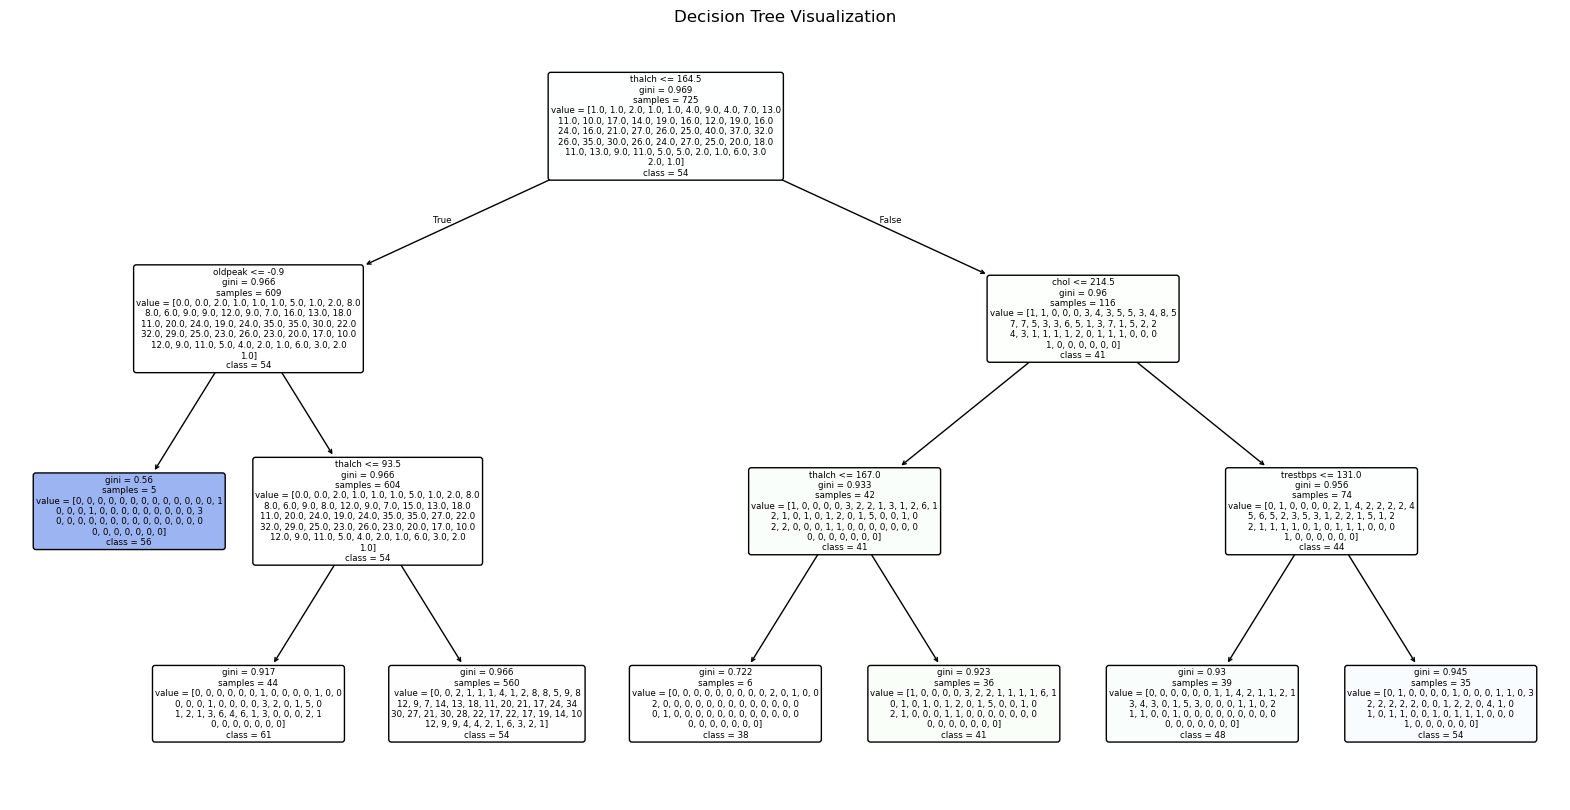

In [40]:
plt.figure(figsize=(20,10))    # visualizing decision tree
plot_tree(best_dec_tree,feature_names=x.columns,class_names=[str(dec_tree) for dec_tree in np.unique(y)], filled=True,rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

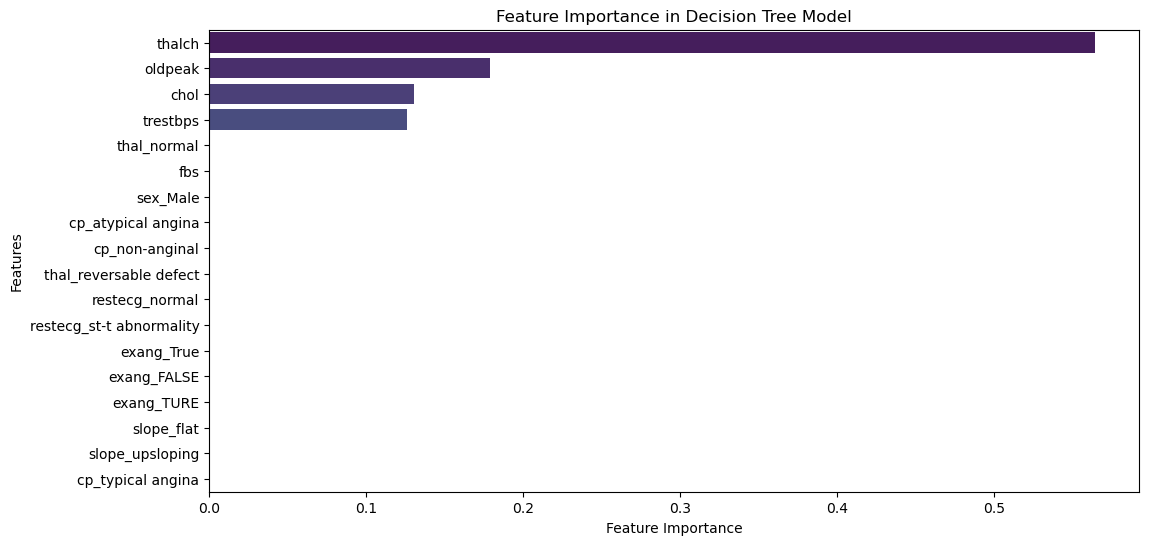

In [41]:
feature_importances = best_dec_tree.feature_importances_
features = x.columns
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances[sorted_indices], y=features[sorted_indices], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree Model")
plt.show()

## Interview Questions:

1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?

   Common Hyperparameters of Decision Treee Models and their effects:
   - Max Depth- Limits tree depth,prevents overfitting if too deep, underfitting if too shallow.
   - Min Samples Split- Minimum samples needed to split a node, higher values reduce overfitting.
   - Min Samples Leaf- Minimum samples in a leaf node,prevents small,insignificant splits,improving generalization.
   - Criterion- Measures split quality(gini or entropy), affects how the tree decides splits.
   - Max Features- Restricts the number of features considered per split, reducing overfitting.

2. What is the difference between the Label encoding and One-hot encoding?

   - Label Encoding: Converts categorical values into numerical labels. Suitable for ordinal data. Can introduce unintended relationships in non-ordinal data.
   - One-Hot Encoding: Converts categorical into binary vectors. Suitable for nominal data. Can increase dimensionality if many unique categories exist.
   - Label encoding assigns numerical values, while One-Hot encoding creates separate binary columns for each category.

   